In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



In [14]:
#Load and preprocess data

otu_path = '/Users/nandini.gadhia/Documents/projects/gp_omics/data/data/Borenstein_1_Yachida_colorectal_cancer/Microbiome_prev_abund_filtered/filtered_yachida_species_A_map2.tsv'
metadata_path = '/Users/nandini.gadhia/Documents/projects/gp_omics/data/data/Borenstein_1_Yachida_colorectal_cancer/Microbiome_prev_abund_filtered/yachida_metadata_map2.tsv'

df_raw = pd.read_csv(otu_path, header=0, index_col=0, sep='\t')
df_meta = pd.read_csv(metadata_path, sep='\t').set_index('sample')

common_samples = df_raw.index.intersection(df_meta.index)
df_raw = df_raw.loc[common_samples]
df_meta = df_meta.loc[common_samples]
df_normalized = df_raw.div(df_raw.sum(axis=1), axis=0)

X = df_normalized.values
y = df_meta['disease_mapping_2'].apply(lambda val: 0 if str(val).endswith('Healthy') else 1).values

print(f"Features matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
if X.shape[0] != y.shape[0]:
    raise ValueError("Mismatch between nsamples in X and y")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Features matrix X shape: (280, 158)
Target vector y shape: (280,)


In [40]:
#Train binary classifier to predict disease (random forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



--- Model Evaluation ---
Accuracy: 0.7381

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.91      0.80        47
           1       0.83      0.51      0.63        37

    accuracy                           0.74        84
   macro avg       0.77      0.71      0.71        84
weighted avg       0.76      0.74      0.72        84




Confusion Matrix:


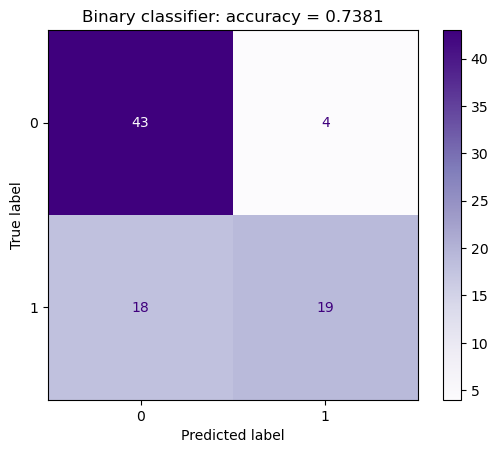

In [41]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title(f"Binary classifier: accuracy = {accuracy_score(y_test, y_pred):.4f}")
plt.show()

In [42]:

print("--- Class Distribution after Train-Test Split ---")

print(f"\nTraining Set Analysis (Total Samples: {len(y_train)}):")
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)

print("Class Counts:")
if len(unique_classes_train) > 0:
    for cls, count in zip(unique_classes_train, counts_train):
        percentage = (count / len(y_train)) * 100
        print(f"  Class '{cls}': {count} samples ({percentage:.2f}%)")
else:
    print("  No samples in the training set.")


print(f"\nTesting Set Analysis (Total Samples: {len(y_test)}):")
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

print("Class Counts:")
if len(unique_classes_test) > 0:
    for cls, count in zip(unique_classes_test, counts_test):
        percentage = (count / len(y_test)) * 100
        print(f"  Class '{cls}': {count} samples ({percentage:.2f}%)")
else:
    print("  No samples in the testing set.")


--- Class Distribution after Train-Test Split ---

Training Set Analysis (Total Samples: 196):
Class Counts:
  Class '0': 110 samples (56.12%)
  Class '1': 86 samples (43.88%)

Testing Set Analysis (Total Samples: 84):
Class Counts:
  Class '0': 47 samples (55.95%)
  Class '1': 37 samples (44.05%)


/var/folders/l5/mpp7rczn7n96jlt9_1s45rkm0000gp/T/ipykernel_30867/1040409388.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


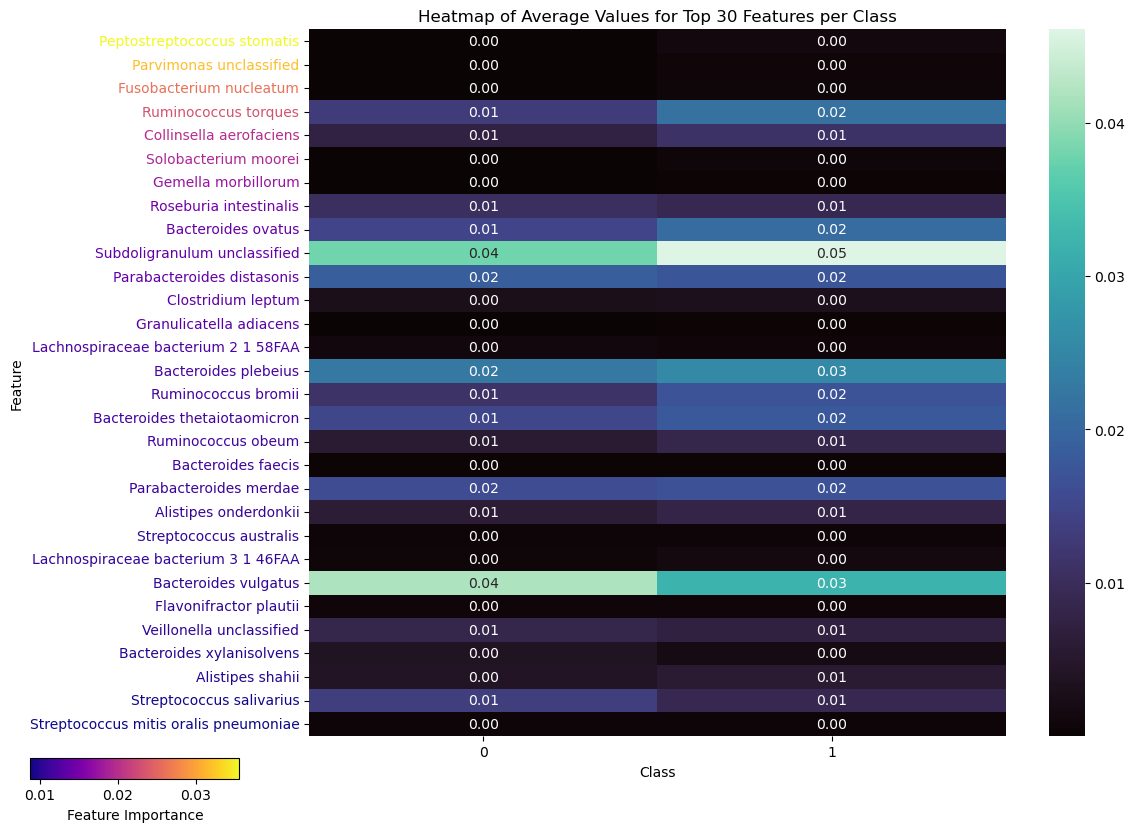

In [44]:
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import LabelEncoder

importances = model.feature_importances_
feature_names = df_raw.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

top_n = 30
top_features_df = feature_importance_df.nlargest(top_n, 'importance')
top_features = top_features_df['feature'].tolist()

X_df = pd.DataFrame(X, columns=df_raw.columns)

# Select the top features
data_to_plot = X_df[top_features].copy()
data_to_plot['target_class'] = y

# Compute average values for each class
average_values = data_to_plot.groupby('target_class').mean()

# Transpose for heatmap: rows = features, columns = classes
average_values_transposed = average_values.T

# Reorder heatmap rows by feature importance
average_values_transposed = average_values_transposed.loc[top_features_df['feature'].values]

# Normalize importance for color mapping
norm = mcolors.Normalize(vmin=top_features_df['importance'].min(), vmax=top_features_df['importance'].max())
cmap = plt.cm.plasma
colors = [cmap(norm(imp)) for imp in top_features_df['importance']]

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    average_values_transposed,
    annot=True,
    cmap="mako",
    fmt=".2f",
    xticklabels=average_values_transposed.columns,
    ax=ax
)
ax.set_title(f'Heatmap of Average Values for Top {top_n} Features per Class')
ax.set_xlabel('Class')
ax.set_ylabel('Feature')

# Color y-axis tick labels
for tick_label, color in zip(ax.get_yticklabels(), colors):
    tick_label.set_color(color)


cax = inset_axes(ax,
                 width="60%",  # Width of colorbar
                 height="3%",  # Height of colorbar
                 loc='lower center',
                 bbox_to_anchor=(-0.5, -0.1, 0.5, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=2)



sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Needed for colorbar
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Feature Importance')

plt.tight_layout()
plt.show()
